In [1]:
import sys
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from pymongo import MongoClient
from tqdm import tqdm
from IPython.display import display

sys.path.append('..')

from pseudoFrameWork.api import getAnyMOEX

mongoClient = MongoClient('localhost', 27017, username='admin', password='admin')
db = mongoClient['rlab_db']

db.list_collection_names()

['q1.CBGoldQuotes',
 'q1.futuresQuotes',
 'q1.RGBIQuotes',
 'q2.YahooFinanceETFMarketData',
 'q1.MREDCQuotes',
 'q3.equityQuotes',
 'futuresList',
 'perpetual.funding',
 'q1.GLDRUB_TOMQuotes',
 'q1.RUCBTRNSQuotes',
 'q1.futuresQuotesContinuous',
 'q3.futuresQuotes',
 'q2.futuresQuotes',
 'q1.IMOEXQuotes']

In [2]:
def insertToDB(name, data, dataBase): dataBase[name].insert_many([data.iloc[i].to_dict() for i in range(data.shape[0])])


In [3]:
futuresInfo = pd.DataFrame(db['futuresList'].find())
futuresInfo = futuresInfo[(~futuresInfo['expiration_date'].isna()) & (~futuresInfo['start_date'].isna())]
futuresInfo = futuresInfo[futuresInfo['secid'].str.len() != 8].reset_index()

for col in ('start_date', 'expiration_date'): futuresInfo[col] = pd.to_datetime(futuresInfo[col])

In [4]:
funding = pd.DataFrame(db['perpetual.funding'].find())
lots = {
    'USDRUBF': 1000,
    'CNYRUBF': 1000,
    'EURRUBF': 1000,
    'GAZPF': 100,
    'SBERF': 100,
}

funding.rename(columns={'Фандинг, руб.': 'fundingRUB'}, inplace=True)
fundingHistory = - funding[['futures', 'fundingRUB']].groupby(by='futures').agg('sum')
fundingHistory.reset_index(inplace=True)
fundingHistory['fundingRUB'] = fundingHistory.apply(lambda x: lots.get(x['futures']) * x['fundingRUB'], axis=1)

fundingHistory = fundingHistory[fundingHistory['futures'] != 'GAZPF']
fundingHistory

,futures,fundingRUB
0,CNYRUBF,-2730.620
1,EURRUBF,-5541.440
3,SBERF,-6146.239
4,USDRUBF,-21165.200


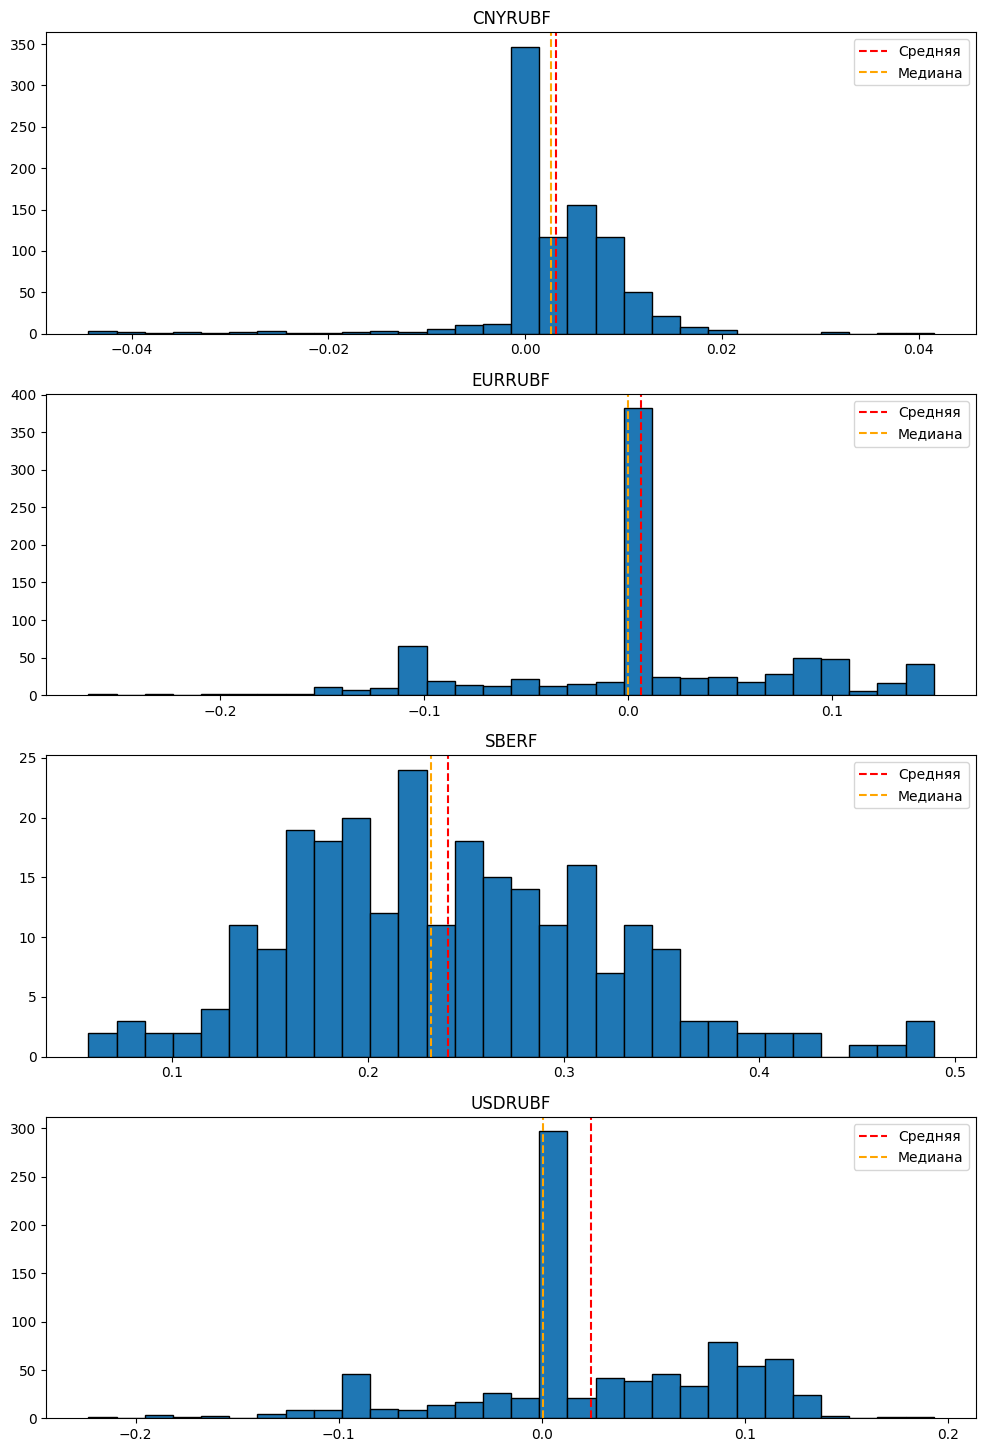

In [5]:
fig, ax = plt.subplots(4, 1, figsize=(12, 18))

for i, futures in enumerate(fundingHistory['futures'].unique()):
    ax[i].hist(funding.loc[funding['futures'] == futures, 'fundingRUB'], bins=30, edgecolor='black')
    ax[i].axvline(funding.loc[funding['futures'] == futures, 'fundingRUB'].mean(), linestyle='--', label='Средняя', color='red')
    ax[i].axvline(funding.loc[funding['futures'] == futures, 'fundingRUB'].median(), linestyle='--', label='Медиана', color='orange')
    ax[i].legend()
    ax[i].set_title(futures)
    

In [6]:
END_DATE = '2025-09-30'

__underlying = futuresInfo[futuresInfo['secid'].isin(funding['futures'].unique())][['secid', 'underlying_asset']].values

underlying = {}

for i in range(len(__underlying)): underlying[__underlying[i, 0]] = __underlying[i, 1]

del __underlying

dates = funding[['Дата', 'futures']].groupby(by='futures').agg('min').to_dict()['Дата']

calendarFutures = pd.DataFrame()

for futures in tqdm(underlying.keys()):
    if futures == 'GAZPF': continue

    dfLoop = futuresInfo.loc[
        (futuresInfo['underlying_asset'] == underlying.get(futures))
        & (futuresInfo['secid'] != futures)
    ].copy()

    # display(futures, dfLoop.sort_values(by='start_date'))

    dfLoop['startTerm'] = (dfLoop['start_date'] - dates.get(futures)).dt.days
    dfLoop['endTerm'] = (dfLoop['expiration_date'] - pd.Timestamp(END_DATE)).dt.days

    datesWithTerm = dfLoop[dfLoop['startTerm'] < 0][['start_date', 'startTerm']]
    datesWithTerm = datesWithTerm[datesWithTerm['startTerm'] == datesWithTerm['startTerm'].max()]

    startDate = datesWithTerm['start_date'].values[0]

    datesWithTerm = dfLoop[dfLoop['endTerm'] > 0][['expiration_date', 'endTerm']]
    datesWithTerm = datesWithTerm[datesWithTerm['endTerm'] == datesWithTerm['endTerm'].min()]

    endDate = datesWithTerm['expiration_date'].values[0]
    
    del datesWithTerm

    dfLoop = dfLoop[ (dfLoop['start_date'] >= startDate) & (dfLoop['expiration_date'] <= endDate) ].sort_values(by='start_date').reset_index()
    
    # display(futures, startDate, endDate)

    futuresList = []

    currentFutures = dfLoop.iloc[0]
    done = False

    while not done:
        if currentFutures['expiration_date'] >= pd.Timestamp(END_DATE): done = True
        
        futuresList.append(currentFutures['secid'])

        currentFutures = dfLoop[dfLoop['start_date'] <= currentFutures['expiration_date']].iloc[-1]

    for __calendarFutures in futuresList:
        __from = pd.Timestamp(dfLoop.loc[dfLoop['secid'] == __calendarFutures, 'start_date'].values[0])
        __till = pd.Timestamp(dfLoop.loc[dfLoop['secid'] == __calendarFutures, 'expiration_date'].values[0])

        quotes = await getAnyMOEX(
            api_method=rf'/iss/history/engines/futures/markets/forts/boards/rfud/securities/{__calendarFutures}.json',
            arguments={'from': __from.strftime('%Y-%m-%d'), 'till': __till.strftime('%Y-%m-%d')},
            field='history',
            all=True
        )

        quotes['perpetual'] = futures

        calendarFutures = pd.concat([calendarFutures, quotes], ignore_index=True)

calendarFutures['price'] = calendarFutures['CLOSE'].combine_first(calendarFutures['SETTLEPRICE'])

for futures in ('EURRUBF', 'USDRUBF', 'SBERF'):
    calendarFutures.loc[calendarFutures['perpetual'] == futures, 'price'] = calendarFutures.loc[calendarFutures['perpetual'] == futures, 'price'] / lots.get(futures)


  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_5408\2868492078.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  calendarFutures = pd.concat([calendarFutures, quotes], ignore_index=True)
100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


In [7]:
calendarFutures

,BOARDID,TRADEDATE,SECID,OPEN,LOW,HIGH,CLOSE,OPENPOSITIONVALUE,VALUE,VOLUME,OPENPOSITION,SETTLEPRICE,SWAPRATE,WAPRICE,SETTLEPRICEDAY,CHANGE,QTY,NUMTRADES,perpetual,price
0,RFUD,2022-04-21,CRU2,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,0,13.06,NaN,NaN,NaN,NaN,NaN,0,CNYRUBF,13.060
1,RFUD,2022-04-22,CRU2,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,0,13.29,NaN,NaN,NaN,NaN,NaN,0,CNYRUBF,13.290
2,RFUD,2022-04-25,CRU2,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,0,12.91,NaN,NaN,NaN,NaN,NaN,0,CNYRUBF,12.910
3,RFUD,2022-04-26,CRU2,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,0,12.82,NaN,NaN,NaN,NaN,NaN,0,CNYRUBF,12.820
4,RFUD,2022-04-27,CRU2,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,0,12.78,NaN,NaN,NaN,NaN,NaN,0,CNYRUBF,12.780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3625,RFUD,2025-11-21,SiZ5,80563.0,79124.0,80660.0,79615.0,6.424320e+11,8.379321e+10,1052157.0,8073898,79569.00,0.0,79634.0,79543.0,-1.18,10.0,215317,USDRUBF,79.615
3626,RFUD,2025-11-24,SiZ5,79633.0,78885.0,79791.0,78998.0,6.394689e+11,5.306906e+10,669658.0,8097618,78970.00,0.0,79242.0,78927.0,-0.78,1.0,132875,USDRUBF,78.998
3627,RFUD,2025-11-25,SiZ5,79013.0,78760.0,79905.0,79122.0,6.429105e+11,8.415584e+10,1059981.0,8126278,79115.00,0.0,79396.0,79876.0,0.16,1.0,218138,USDRUBF,79.122
3628,RFUD,2025-11-26,SiZ5,79144.0,78804.0,79353.0,79045.0,6.358957e+11,4.479433e+10,566822.0,8046766,79025.00,0.0,79024.0,78899.0,-0.10,9.0,128785,USDRUBF,79.045


In [8]:

rolloverData = pd.DataFrame()

for futures in calendarFutures['perpetual'].unique():
    loop = pd.DataFrame()

    calendarList = calendarFutures.loc[calendarFutures['perpetual'] == futures, 'SECID'].unique()

    rollover = []
    
    for i in range(1, len(calendarList)):
        date = pd.Timestamp(futuresInfo.loc[futuresInfo['secid'] == calendarList[i], 'start_date'].values[0]).strftime('%Y-%m-%d')
        
        __rollover = calendarFutures.loc[ (calendarFutures['SECID'] == calendarList[i]) & (calendarFutures['TRADEDATE'] == date), 'price' ].values[0] \
        - calendarFutures.loc[ (calendarFutures['SECID'] == calendarList[i-1]) & (calendarFutures['TRADEDATE'] == date), 'price' ].values[0]

        rollover.append(__rollover)

    loop['rollover'] = rollover
    loop['perpetual'] = futures

    rolloverData = pd.concat([rolloverData, loop], ignore_index=True)

        
        


    

In [9]:
rolloverData = - rolloverData.groupby(by='perpetual').agg('sum')
rolloverData.reset_index(inplace=True)
rolloverData['rollover'] = rolloverData.apply(lambda x: lots.get(x['perpetual']) * x['rollover'], axis=1)

rolloverData


,perpetual,rollover
0,CNYRUBF,-3822.0
1,EURRUBF,-14482.0
2,SBERF,740.0
3,USDRUBF,-13716.0


In [10]:
fundingWithCloseDeals = pd.DataFrame()

for j, futures in enumerate(rolloverData['perpetual']):
    loop = funding[funding['futures'] == futures].copy().reset_index()

    __fund = 0
    realized = 0

    for i in range(len(loop) - 1):
        if loop.loc[i, 'fundingRUB'] <= 0: __fund += loop.loc[i, 'fundingRUB']
        else: realized += loop.loc[i + 1, 'Расчетная цена вечернего клиринга'] - loop.loc[i, 'Расчетная цена вечернего клиринга']
    
    fundingWithCloseDeals.loc[j, 'perpetual'] = futures
    fundingWithCloseDeals.loc[j, 'fund'] = __fund
    fundingWithCloseDeals.loc[j, 'realized'] = realized

fundingWithCloseDeals['result'] = - (fundingWithCloseDeals['fund'] + fundingWithCloseDeals['realized'] )
fundingWithCloseDeals['result'] = fundingWithCloseDeals.apply(lambda x: lots.get(x['perpetual']) * x['result'], axis=1)
    

In [11]:
fundingWithCloseDeals


,perpetual,fund,realized,result
0,CNYRUBF,-0.75731,-1.794,2551.31
1,EURRUBF,-17.95705,-3.140,21097.05
2,SBERF,0.00000,22.300,-2230.00
3,USDRUBF,-11.44930,10.370,1079.30
